In [1]:
%pylab inline
%matplotlib inline

# Global Imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import os
import sys
import pickle
from pprint import pprint
from time import time
import datetime
from time import gmtime, strftime

# Scikit-Learn imports
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


# Local Imports
path = str(os.path.expanduser('~')) + '/git/predictEPL/config'
sys.path.append(path)
import paths

sys.path.append(paths.UTILS)
import useful_methods

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Print Training Parameters
def DetecterParams(detecter, title="", all_tunes=True):
    print("\n\n### PARAMS ################################\n")

    if all_tunes:
        print("[All Params Results]:\n")
        pprint(detecter.grid_scores_)
        print("\n")

    print("[%s Detecter Params]: \n" % title)
    print("Best Score: ", detecter.best_score_)
    print("Best Params: ", detecter.best_params_)


# Print Test Prediction
def DetecterMetrics(features, labels, detecter, title=""):
    predictions = detecter.predict(features)
    print("\n\n### METRICS ###############################\n")

    print("[%s Results]: \n" % title)
    print(classification_report(labels, predictions))
    print('[Accuracy]: ', accuracy_score(labels, predictions))


# Receiver Operating Characteristic = ROC curve
# Visualizes a classifier's performance
# for all values of the discrimination threshold. 
# fall out: F = FP / (TN + FP)
# AUC (area under the curve)
def PlotRocAuc(features, labels, detecter, title=""):
    # predict features
    predictions = detecter.predict_proba(features)
    
    # calculate Fall Out & Recall
    false_positive_rate, recall, thresholds = roc_curve(
        labels, predictions[:, 1])

    # ROC AUC
    roc_auc = auc(false_positive_rate, recall)

    # Plot
    plt.title('Receiver Operating Characteristic: ' + title)
    plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)

    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.show()

In [78]:
# Define Logistic Recression
def Log(y_train, n_folds=100):
    # putting the steps explicitly into Pipeline
    pipeline_log = Pipeline([
            ('clf', LogisticRegression())
        ])

    # tunning parameters
    params_log = {
        'clf__C': (1, 10, 100),
#         'clf__penalty': ('l1', 'l2')
    }

    # grid search
    grid_log = GridSearchCV(
        pipeline_log,        # pipeline from above
        params_log,          # parameters to tune via cross validation
        refit=True,          # fit using all available data at the end, on the best found param combination
        n_jobs=-1,           # number of cores to use for parallelization; -1 for "all cores"
        scoring='accuracy',  # what score are we optimizing?
#         cv=StratifiedKFold(y_train, n_folds=n_folds),  # what type of cross validation to use
#         cv=n_folds
    )

    return grid_log

In [113]:
date_now = strftime("%Y-%m-%d %H:%M:%S", gmtime()).replace(" ", "_")

# ***************************************************
# [Step 1]: Data Load
# ***************************************************

# Read Data
df = useful_methods.csv_dic_df(paths.DATA_HOME + "EPL/all_game_emolex_counted.csv")

# Manipulations

dic_res ={
    'home_win': 1,
    'away_win': 0,
    'draw': 2
}

def Labeling(goal_diff):
    if goal_diff > 0:
        return 1
    elif goal_diff < 0:
        return 0
    else:
        return 2

df.score_ft_home = [int(score_ft_home) for score_ft_home in df.score_ft_home]
df.score_ft_away = [int(score_ft_away) for score_ft_away in df.score_ft_away]

df.pos_home = [float(pos_home) for pos_home in df.pos_home]
df.pos_away = [float(pos_away) for pos_away in df.pos_away]
df.neg_home = [float(neg_home) for neg_home in df.neg_home]
df.neg_away = [float(neg_away) for neg_away in df.neg_away]

df.emolex_home = [np.array([float(emo) for emo in emolex_home[1:-1].split(',')]) for emolex_home in list(df.emolex_home)]
df.emolex_away = [np.array([float(emo) for emo in emolex_away[1:-1].split(',')]) for emolex_away in list(df.emolex_away)]

df['goal_diff'] = df.score_ft_home - df.score_ft_away
df['result'] = [Labeling(goal_diff) for goal_diff in df.goal_diff]
# df = df[df.result != 2].copy().reset_index(drop=True)
df

,GW,away_team,date,emolex_away,emolex_home,home_team,neg_away,neg_home,pos_away,pos_home,score_ft_away,score_ft_home,score_ht_away,score_ht_home,time,goal_diff,result
0,5,Chelsea,Sat. 12 Sep.,"[1732.0, 1670.0, 1436.0, 1569.0, 1079.0, 2217....","[405.0, 287.0, 192.0, 322.0, 291.0, 484.0, 530...",Everton,3699,647,3901,1009,1,3,1,2,11:45,2,1
1,5,Bournemouth,Sat. 12 Sep.,"[36.0, 36.0, 25.0, 22.0, 27.0, 50.0, 37.0, 37.0]","[67.0, 64.0, 22.0, 54.0, 122.0, 194.0, 122.0, ...",Norwich,53,100,112,331,1,3,0,1,14:00,2,1
2,5,Swansea,Sat. 12 Sep.,"[24.0, 23.0, 10.0, 20.0, 22.0, 51.0, 33.0, 46.0]","[38.0, 22.0, 18.0, 20.0, 57.0, 66.0, 52.0, 58.0]",Watford,36,55,78,98,0,1,0,0,14:00,1,1
3,5,Southampton,Sat. 12 Sep.,"[23.0, 28.0, 17.0, 23.0, 75.0, 65.0, 68.0, 67.0]","[56.0, 30.0, 38.0, 32.0, 43.0, 80.0, 48.0, 94.0]",WestBromwich,62,116,154,116,0,0,0,0,14:00,0,2
4,5,Stoke,Sat. 12 Sep.,"[82.0, 59.0, 40.0, 47.0, 75.0, 130.0, 107.0, 8...","[603.0, 445.0, 421.0, 432.0, 1039.0, 1681.0, 1...",Arsenal,113,938,255,2529,0,2,0,1,14:00,2,1
5,5,City,Sat. 12 Sep.,"[1029.0, 1358.0, 538.0, 805.0, 441.0, 378.0, 3...","[146.0, 113.0, 60.0, 80.0, 100.0, 190.0, 145.0...",Crystal,1708,225,975,299,1,0,0,0,14:00,-1,0
6,5,Liverpool,Sat. 12 Sep.,"[1743.0, 1955.0, 1644.0, 1838.0, 1207.0, 2875....","[5228.0, 3026.0, 2403.0, 2447.0, 2705.0, 7167....",United,4464,9999,4881,11807,1,3,0,0,16:30,2,1
7,5,Tottenham,Sun. 13 Sep.,"[379.0, 365.0, 248.0, 315.0, 297.0, 511.0, 421...","[158.0, 152.0, 87.0, 120.0, 205.0, 329.0, 218....",Sunderland,815,330,1117,498,1,0,0,0,12:30,-1,0
8,5,Villa,Sun. 13 Sep.,"[195.0, 233.0, 203.0, 191.0, 384.0, 725.0, 881...","[70.0, 75.0, 74.0, 65.0, 99.0, 122.0, 99.0, 10...",Leicester,480,163,1550,276,2,3,1,0,15:00,1,1
9,5,Newcastle,Mon. 14 Sep.,"[589.0, 697.0, 473.0, 643.0, 418.0, 919.0, 574...","[96.0, 92.0, 64.0, 68.0, 147.0, 401.0, 297.0, ...",WestHam,1563,202,1560,655,0,2,0,1,19:00,2,1


In [114]:
X = []

for i in range(len(df)):
    X.append(np.array(
                np.r_[
                df.pos_home[i] / (df.pos_home[i] + df.neg_home[i]),
                df.pos_away[i] / (df.pos_away[i] + df.neg_away[i]),
                df.emolex_home[i] / sum(df.emolex_home[i]),
                df.emolex_away[i] / sum(df.emolex_away[i]),
            ],
            ))

X = np.array(X)
y = np.array(df.result)
X

array([[ 0.60929952,  0.51328947,  0.13682432, ...,  0.16723241,
         0.12408539,  0.1439994 ],
       [ 0.76798144,  0.67878788,  0.08220859, ...,  0.18518519,
         0.13703704,  0.13703704],
       [ 0.64052288,  0.68421053,  0.11480363, ...,  0.22270742,
         0.1441048 ,  0.20087336],
       ..., 
       [ 0.62662338,  0.68713789,  0.08020478, ...,  0.2600321 ,
         0.16532905,  0.17281969],
       [ 0.52690864,  0.54840785,  0.16216216, ...,  0.17848294,
         0.15399276,  0.13140842],
       [ 0.60274791,  0.65918803,  0.11333572, ...,  0.19550265,
         0.19616402,  0.17010582]])

In [115]:
# ***************************************************
# [Step 2]: Data Split(train=0.8, test=0.2)
# ***************************************************

# Split data Train and Test data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

print(
    "\n\n### DATA ##################################\n",
    "\n\tTrain data: \t", len(X_train),
    "\n\tTest data: \t", len(X_test),
    "\n\tAll data: \t", len(y_train) + len(y_test)
)

# ***************************************************
# [Step 3]: Define Classifier
# ***************************************************

grid_search = Log(y_train)

# ***************************************************
# [Step 4]: Compute Classifier
# ***************************************************

start_time = time()

# fitting training sets to classifier
grid_search.fit(X_train, y_train)

# ***************************************************
# [Step 4]: Print Classifier Details
# ***************************************************

# print trained parameters
DetecterParams(grid_search, title="Log")

# print computed time
print("\n\n### COMPUTED TIME #########################\n")
taken_time = time() - start_time
print("[Started Time]: ", date_now)
print("\n[Taken Time]: ", str(datetime.timedelta(seconds=taken_time)))

# print classifier test results
DetecterMetrics(X_train, y_train, grid_search, title="Train")
DetecterMetrics(X_test, y_test, grid_search, title="Test")



### DATA ##################################
 
	Train data: 	 117 
	Test data: 	 30 
	All data: 	 147


### PARAMS ################################

[All Params Results]:

[mean: 0.44444, std: 0.00612, params: {'clf__C': 1},
 mean: 0.48718, std: 0.01813, params: {'clf__C': 10},
 mean: 0.42735, std: 0.00628, params: {'clf__C': 100}]


[Log Detecter Params]: 

Best Score:  0.487179487179
Best Params:  {'clf__C': 10}


### COMPUTED TIME #########################

[Started Time]:  2016-01-16_12:47:00

[Taken Time]:  0:00:00.190773


### METRICS ###############################

[Train Results]: 

             precision    recall  f1-score   support

          0       0.61      0.44      0.51        32
          1       0.53      0.92      0.67        52
          2       1.00      0.09      0.17        33

avg / total       0.68      0.56      0.48       117

[Accuracy]:  0.555555555556


### METRICS ###############################

[Test Results]: 

             precision    recall  f1-sc

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


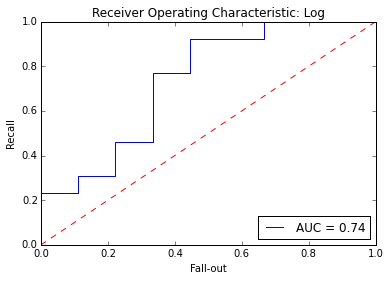

In [111]:
PlotRocAuc(X_test, y_test, grid_search, title="Log")